In [134]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from ens_util import *
from math import isnan
from sklearn.calibration import calibration_curve
plt.rcParams['figure.figsize'] = [9,9]

In [2]:
data_files = glob('data_crop*.nc')
res_files = glob('2014*Z_crs_gauss.nc')
coordx = [258,260]
coordy = [63,65]
thresh = 0.2
data = build_datadf(data_files,coordx,coordy)
(fr15,fr30,fr45,fr60) = build_weighted_fractions(res_files,data.index,data.columns,coordx,coordy,thresh)
fr = [fr15,fr30,fr45,fr60]

In [3]:
index_dates = data.index.date
index_dates_unique = np.unique(index_dates)
index_times = data.index
bs15 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs30 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs45 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs60 = pd.DataFrame(index=index_dates_unique,columns=data.columns)
bs = [bs15,bs30,bs45,bs60]

In [49]:
#Better way to do the brier score calculations

data_bin = data.mask(data<thresh,other=1)
data_bin = data_bin.mask(data_bin!=1.0,other=0)

for c in data.columns:
    for d in index_dates_unique:
        times = index_times[np.where(index_dates==d)]
        sat = data_bin.loc[times,[c]]
        for f in range(4):
            frac = fr[f].loc[times,[c]]
            bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
            valid = np.where(np.invert(np.isnan(bs_vals)))
            bs[f].at[d,c] = np.sum(bs_vals[valid])/len(bs_vals[valid])

In [83]:
#Brier Score decomposition
c=0
f=0
d=index_dates_unique[0]
times = index_times[np.where(index_dates==d)]
sat = data_bin.loc[times,[c]]
frac = fr[f].loc[times,[c]]

bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
sat_vals = sat.values[:,0].astype(np.float)
frac_vals = frac.values[:,0].astype(np.float)

valid = np.where(np.invert(np.isnan(bs_vals)))
bs_valid = bs_vals[valid]
sat_valid = sat_vals[valid]
frac_valid = frac_vals[valid]
print(bs_valid,sat_valid,frac_valid)

[1.60000000e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.25314633e-05 1.07480330e-02 8.46513614e-02 5.97397650e-03
 1.04565039e-01 2.49281880e-08 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [0.6        1.         1.         1.         1.         1.
 1.         1.         0.99646002 0.89632728 0.70905093 0.9227085
 0.67663482 0.99984211 1.         1.         1.         1.        ]


In [86]:
# Follows Wilks Ch. 8
unique,counts = np.unique(frac_valid,return_counts=True) #counts are N_i values
n = np.sum(counts) # n

obar_i = np.zeros(len(unique))
for j in range(len(unique)):
    y = unique[j]
    wh = np.where(frac_valid==y)
    obar_i[j] = np.sum(sat_valid[wh])/counts[j]

obar = np.sum(sat_valid)/n

sig = obar*(1-obar)
rel = np.sum(np.multiply(counts,(unique-obar_i)**2))/n
res = np.sum(np.multiply(counts,(obar_i-obar)**2))/n

print(rel,res,sig,rel-res+sig)

0.020330609235287286 0.0 0.0 0.020330609235287286


In [139]:
# would have to create new columns for each coordinate location
dec15 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs'])
dec30 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs'])
dec45 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs'])
dec60 = pd.DataFrame(index=index_dates_unique,columns=['rel','res','sig','bs'])
dec = [dec15,dec30,dec45,dec60]

c=0
for d in index_dates_unique:
    times = index_times[np.where(index_dates==d)]
    sat = data_bin.loc[times,[c]]
    for f in range(4):
        frac = fr[f].loc[times,[c]]
        bs_vals = ((frac-sat)**2).values[:,0].astype(np.float)
        sat_vals = sat.values[:,0].astype(np.float)
        frac_vals = frac.values[:,0].astype(np.float)
        valid = np.where(np.invert(np.isnan(bs_vals)))
        bs_valid = bs_vals[valid]
        sat_valid = sat_vals[valid]
        frac_valid = frac_vals[valid]
        
        unique,counts = np.unique(frac_valid,return_counts=True)
        n = np.sum(counts)
        obar_i = np.zeros(len(unique))
        for j in range(len(unique)):
            y = unique[j]
            wh = np.where(frac_valid==y)
            obar_i[j] = np.sum(sat_valid[wh])/counts[j]
        obar = np.sum(sat_valid)/n

        sig = obar*(1-obar)
        rel = np.sum(np.multiply(counts,(unique-obar_i)**2))/n
        res = np.sum(np.multiply(counts,(obar_i-obar)**2))/n
        dec[f].at[d,'rel'] = rel
        dec[f].at[d,'res'] = res
        dec[f].at[d,'sig'] = sig
        dec[f].at[d,'bs'] = rel-res+sig
print(dec60)

                    rel          res        sig           bs
2014-04-02    0.0804296            0          0    0.0804296
2014-04-05     0.163764         0.16       0.16     0.163764
2014-04-09    0.0126579            0          0    0.0126579
2014-04-10   0.00269948            0          0   0.00269948
2014-04-11     0.234351     0.222222   0.222222     0.234351
2014-04-12     0.445987    0.0812698   0.195556     0.560273
2014-04-15    0.0833271     0.115556   0.115556    0.0833271
2014-04-18    0.0494497            0          0    0.0494497
2014-04-19      0.20143         0.24       0.24      0.20143
2014-04-20   0.00161252            0          0   0.00161252
2014-04-21  0.000683395            0          0  0.000683395
2014-04-22   0.00177875            0          0   0.00177875
2014-04-25   0.00798772            0          0   0.00798772
2014-04-26     0.233065         0.16       0.16     0.233065
2014-05-05   0.00266667            0          0   0.00266667
2014-05-06    0.0897446 

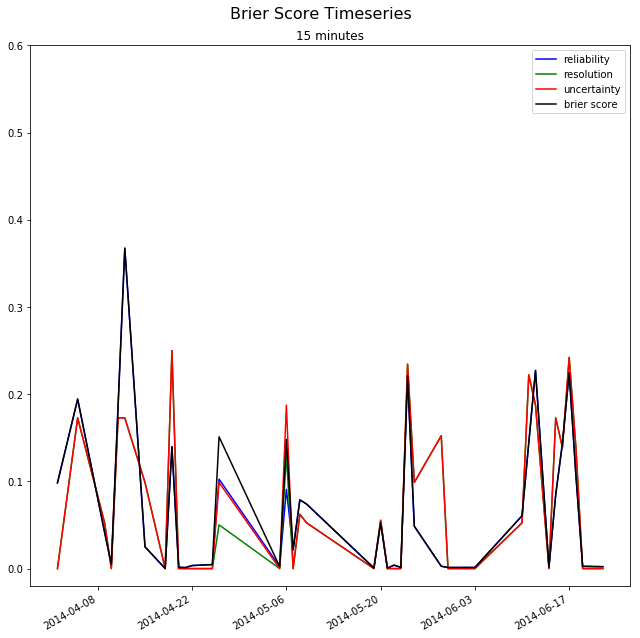

In [138]:
ymin= -0.02
ymax = 0.6
rows = 1; cols = 1;
fig,ax = plt.subplots(rows,cols)
ax.set_ylim([ymin,ymax])

ax.plot(dec15.index,dec30.values[:,0],c='b',label='reliability')
ax.plot(dec15.index,dec30.values[:,1],c='g',label='resolution')
ax.plot(dec15.index,dec30.values[:,2],c='r',label='uncertainty')
ax.plot(dec15.index,dec30.values[:,3],c='k',label='brier score')

ax.set_title("15 minutes")

fig.autofmt_xdate()
fig.tight_layout()
fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.legend()
plt.show()

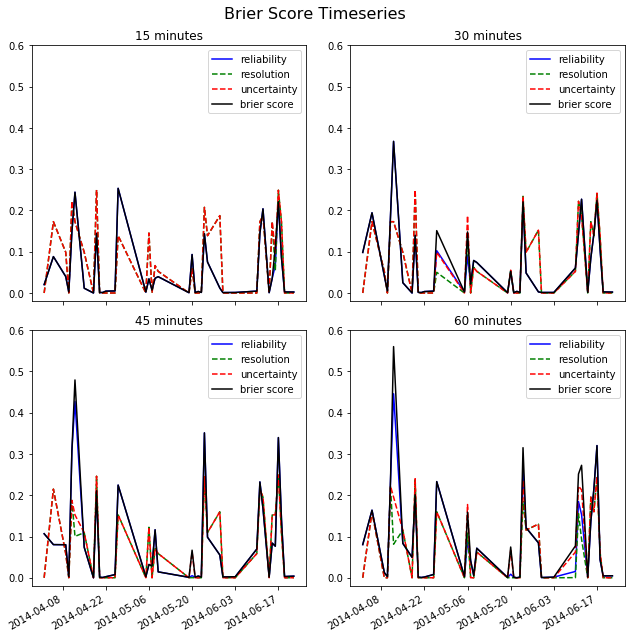

In [136]:
coord = 0
ymin= -0.02
ymax = 0.6
rows = 2; cols = 2;
fig,axarr = plt.subplots(rows,cols)
for r in range(rows):
    for c in range(cols):
        axarr[r,c].set_ylim([ymin,ymax])
        

        
axarr[0,0].plot(dec15.index,dec15.values[:,0],c='b',label='reliability')
axarr[0,0].plot(dec15.index,dec15.values[:,1],c='g',ls='--',label='resolution')
axarr[0,0].plot(dec15.index,dec15.values[:,2],c='r',ls='--',label='uncertainty')
axarr[0,0].plot(dec15.index,dec15.values[:,3],c='k',label='brier score')

axarr[0,1].plot(dec15.index,dec30.values[:,0],c='b',label='reliability')
axarr[0,1].plot(dec15.index,dec30.values[:,1],c='g',ls='--',label='resolution')
axarr[0,1].plot(dec15.index,dec30.values[:,2],c='r',ls='--',label='uncertainty')
axarr[0,1].plot(dec15.index,dec30.values[:,3],c='k',label='brier score')

axarr[1,0].plot(dec15.index,dec45.values[:,0],c='b',label='reliability')
axarr[1,0].plot(dec15.index,dec45.values[:,1],c='g',ls='--',label='resolution')
axarr[1,0].plot(dec15.index,dec45.values[:,2],c='r',ls='--',label='uncertainty')
axarr[1,0].plot(dec15.index,dec45.values[:,3],c='k',label='brier score')

axarr[1,1].plot(dec15.index,dec60.values[:,0],c='b',label='reliability')
axarr[1,1].plot(dec15.index,dec60.values[:,1],c='g',ls='--',label='resolution')
axarr[1,1].plot(dec15.index,dec60.values[:,2],c='r',ls='--',label='uncertainty')
axarr[1,1].plot(dec15.index,dec60.values[:,3],c='k',label='brier score')

axarr[0,0].set_title("15 minutes")
axarr[0,1].set_title("30 minutes")
axarr[1,0].set_title("45 minutes")
axarr[1,1].set_title("60 minutes")

axarr[0,0].legend()
axarr[0,1].legend()
axarr[1,0].legend()
axarr[1,1].legend()

fig.autofmt_xdate()
fig.tight_layout()
fig.suptitle("Brier Score Timeseries",fontsize=16)
fig.subplots_adjust(top=0.92)
plt.show()

4/12, 6/18, 5/24 case studies

reference BS can be anything I want

compute overall brier score; one long timeseries, not average of individual brier scores.
change lines to bar charts, spread out length wise
look at adjustments to model statistics

do enhanced reliability diagram - read text for reminder.

"climatological" benchmark? fraction of cloudy/not over the entire timeseries at a single point.
Or: do it over the entire grid.